In [1]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_validate, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

from sklearn.linear_model import LinearRegression, Lasso, Ridge

# Clean

In [12]:
train = pd.read_csv('https://raw.githubusercontent.com/ryskgit/QTW_CaseStudy/main/Case%20Study%201/Raw%20Data%201/train.csv')
material = pd.read_csv('https://raw.githubusercontent.com/ryskgit/QTW_CaseStudy/main/Case%20Study%201/Raw%20Data%201/unique_m.csv')

In [ ]:
# train = pd.read_csv('https://raw.githubusercontent.com/ryskgit/QTW_CaseStudy/main/Case%20Study%201/Raw%20Data%201/train.csv')
# material = pd.read_csv('https://raw.githubusercontent.com/ryskgit/QTW_CaseStudy/main/Case%20Study%201/Raw%20Data%201/unique_m.csv')
# df = train.merge(material, on='critical_temp', how='left')

In [13]:
train.drop(columns=['critical_temp'], inplace=True)
df = pd.concat([train, material], axis=1)

In [14]:
df.drop(columns=['material'], inplace=True)

In [15]:
single_vals = df.columns[df.eq(df.iloc[0]).all()].tolist()
print (single_vals)

['He', 'Ne', 'Ar', 'Kr', 'Xe', 'Pm', 'Po', 'At', 'Rn']


In [16]:
df.drop(columns=single_vals, inplace=True)

In [17]:
df.isna().sum().sum()

0

In [18]:
df.duplicated().sum()

0

In [19]:
df.shape

(21263, 159)

In [20]:
df.head()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,Re,Os,Ir,Pt,Au,Hg,Tl,Pb,Bi,critical_temp
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21263 entries, 0 to 21262
Columns: 159 entries, number_of_elements to critical_temp
dtypes: float64(156), int64(3)
memory usage: 25.8 MB


# EDA

In [ ]:
# correlation plot

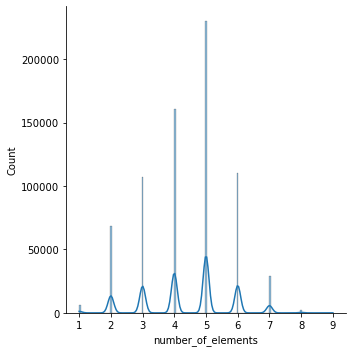

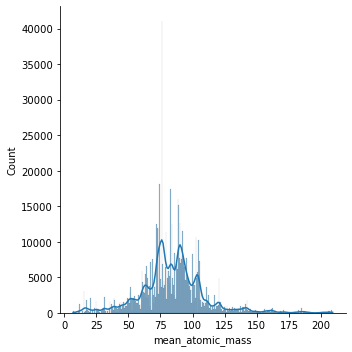

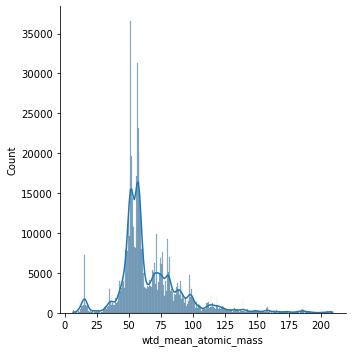

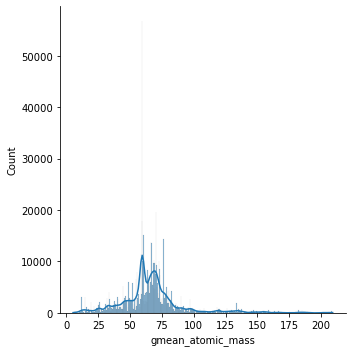

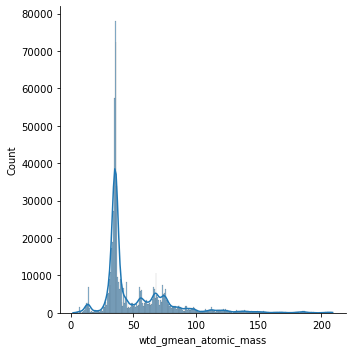

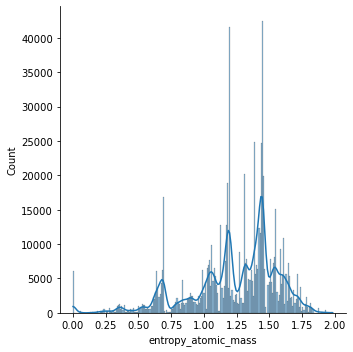

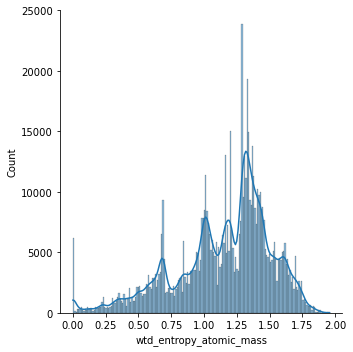

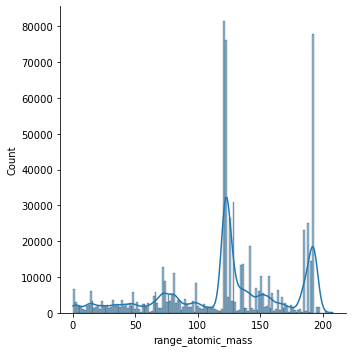

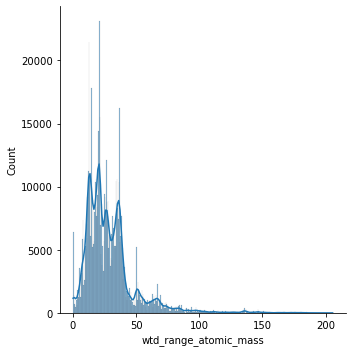

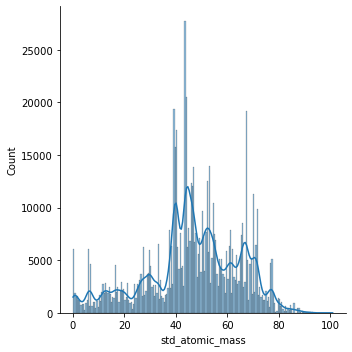

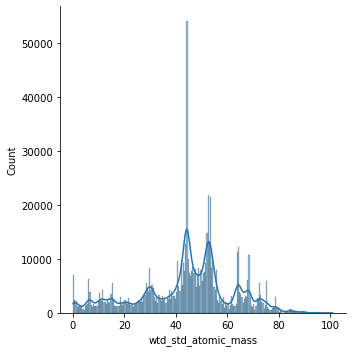

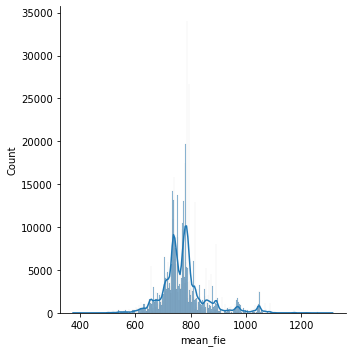

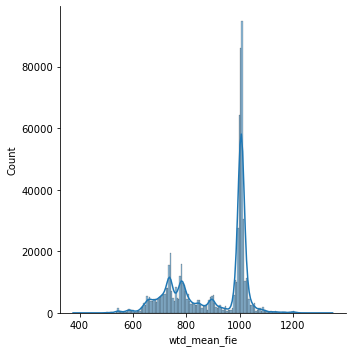

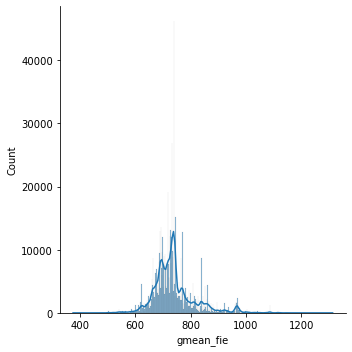

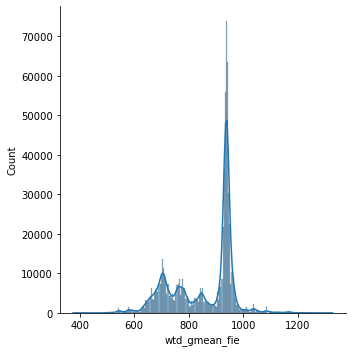

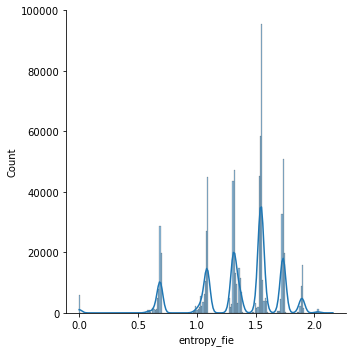

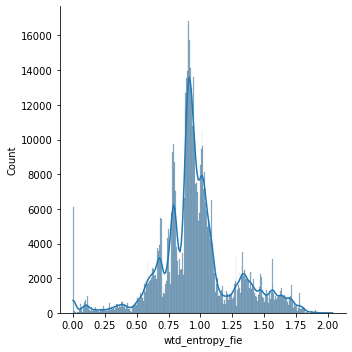

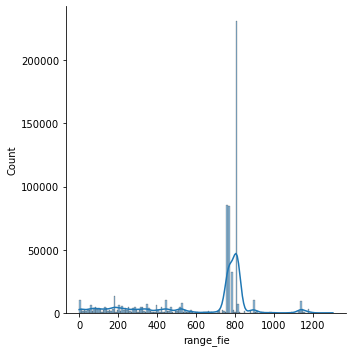

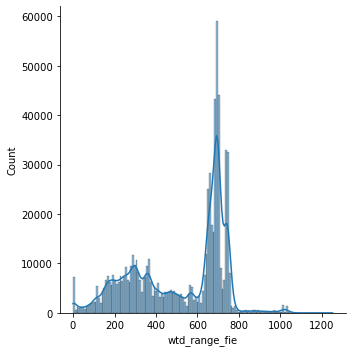

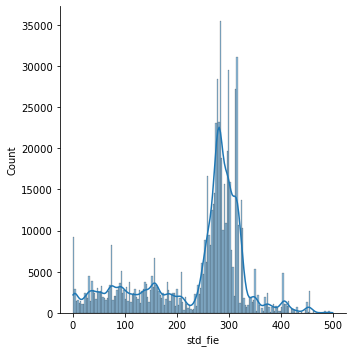

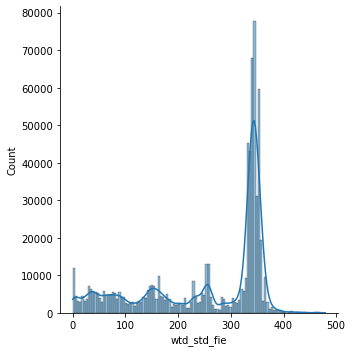

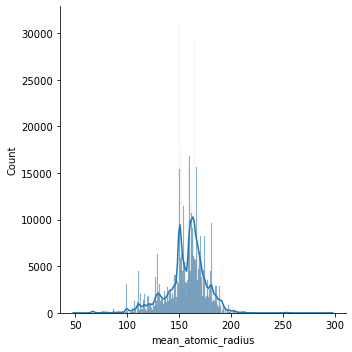

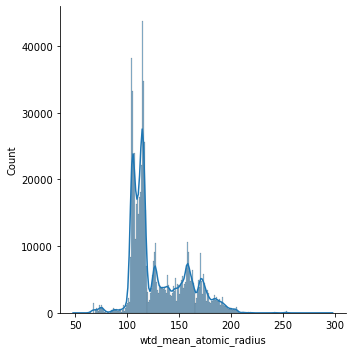

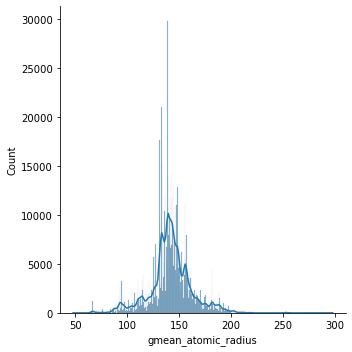

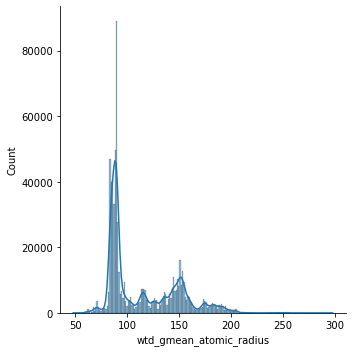

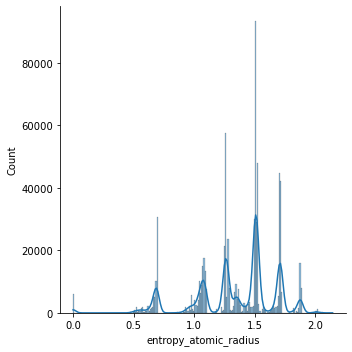

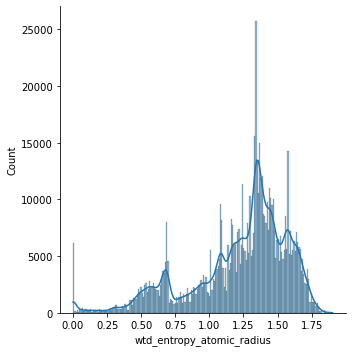

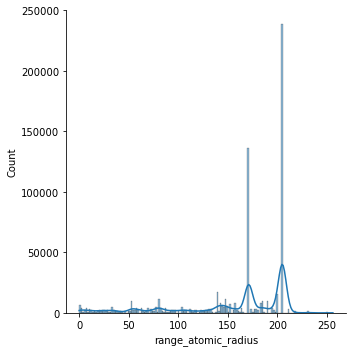

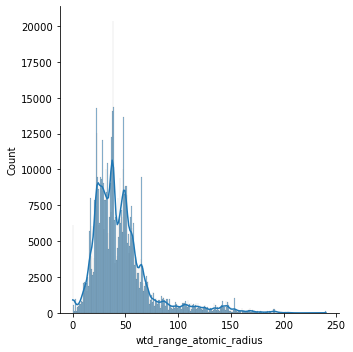

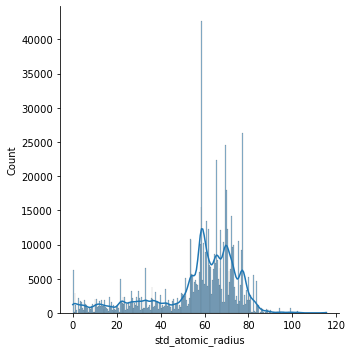

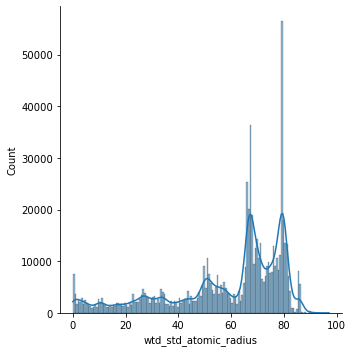

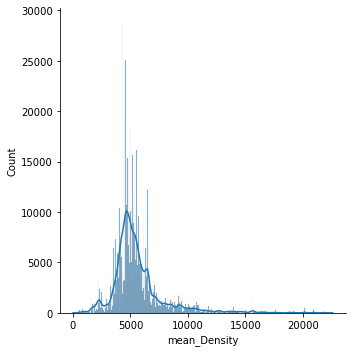

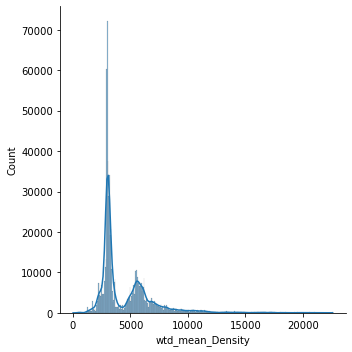

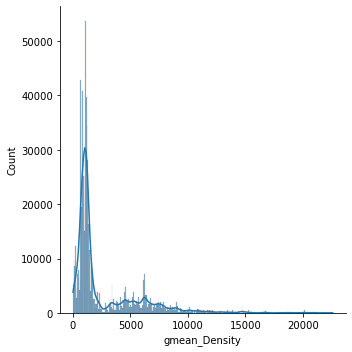

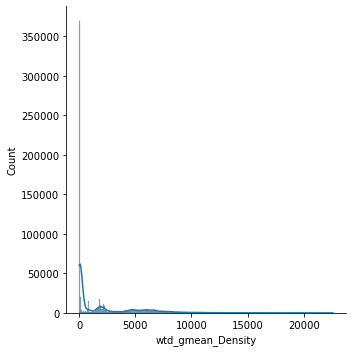

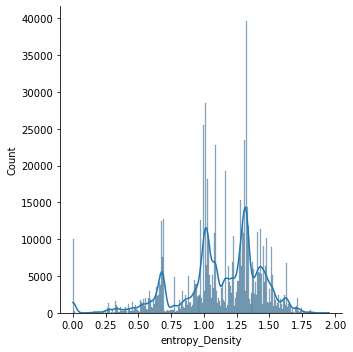

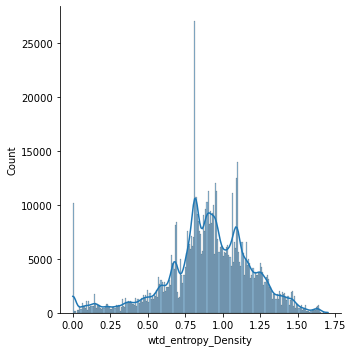

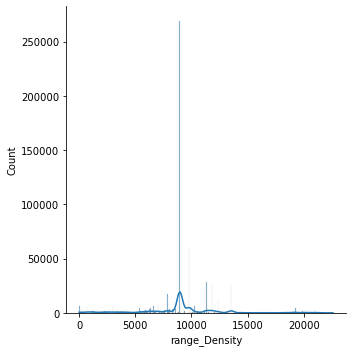

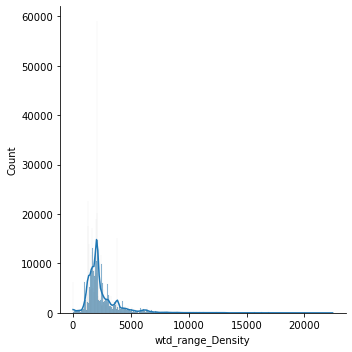

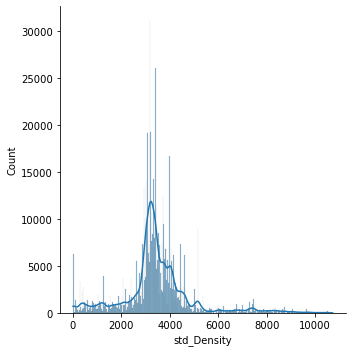

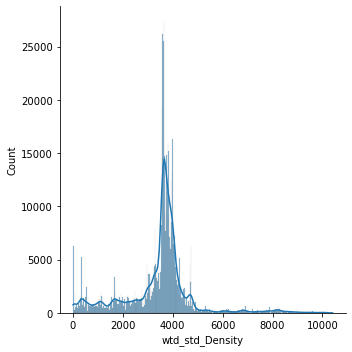

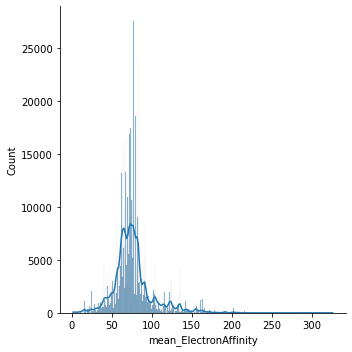

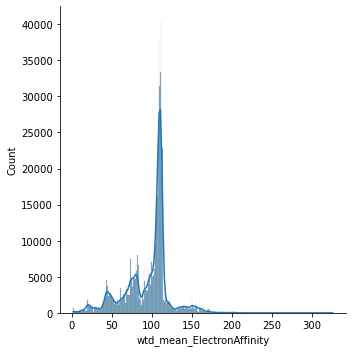

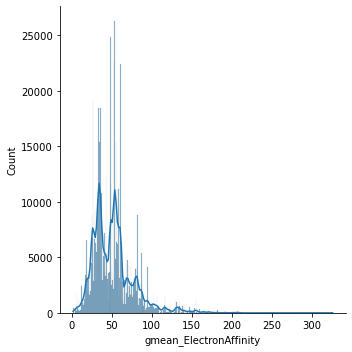

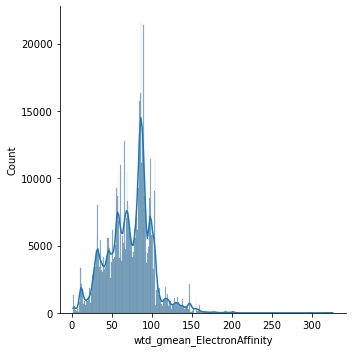

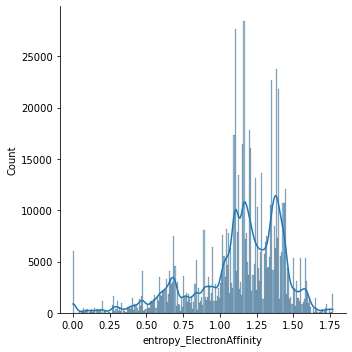

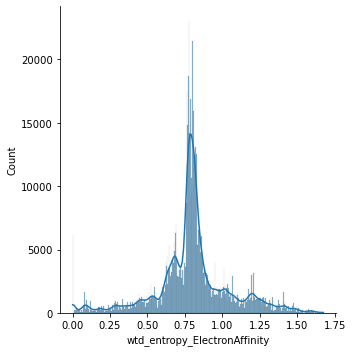

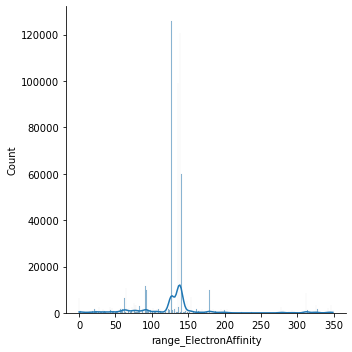

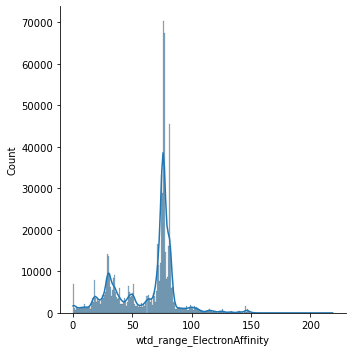

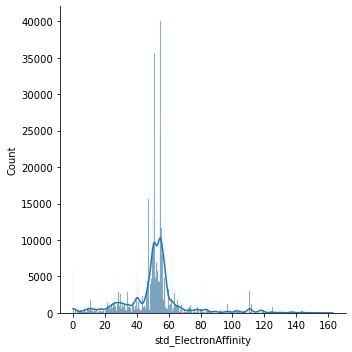

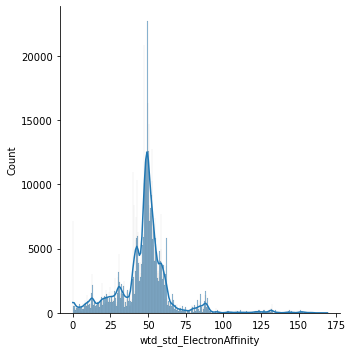

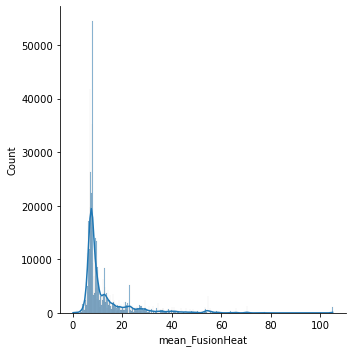

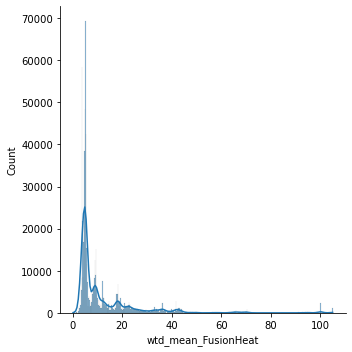

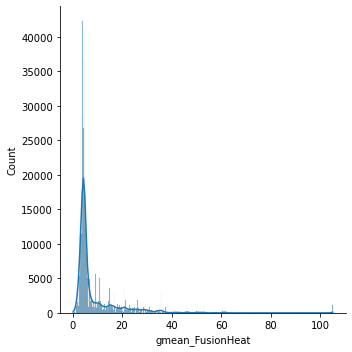

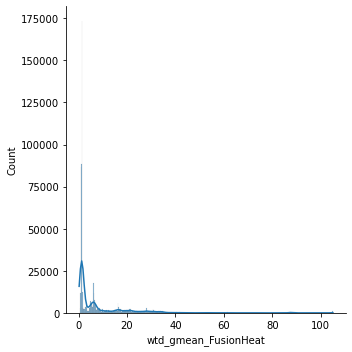

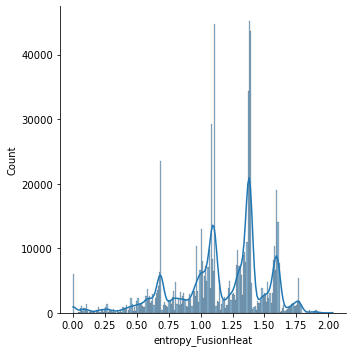

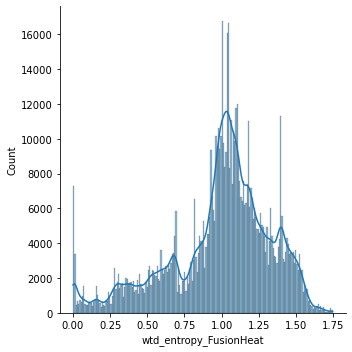

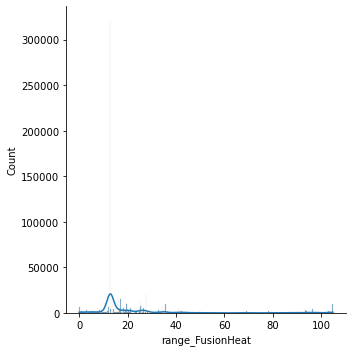

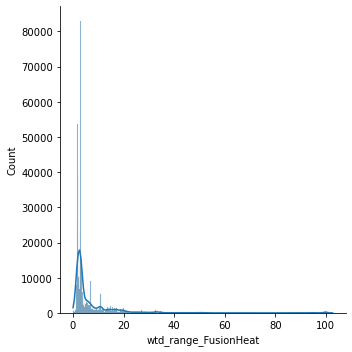

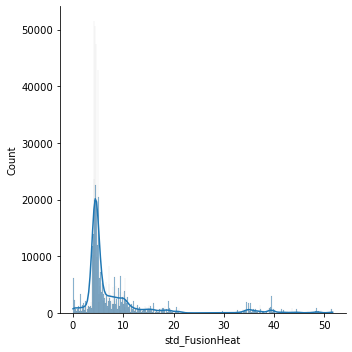

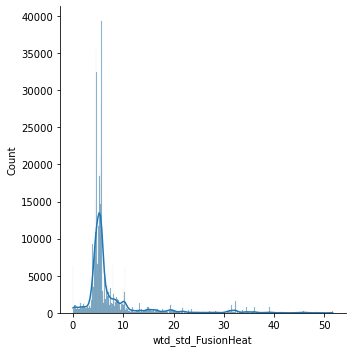

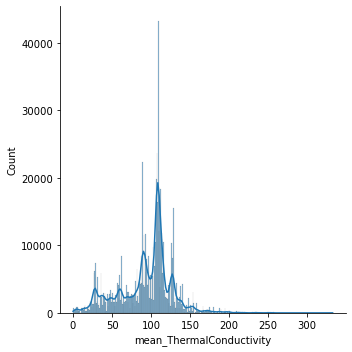

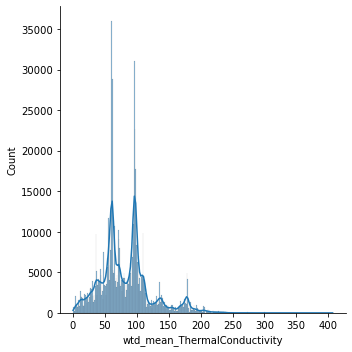

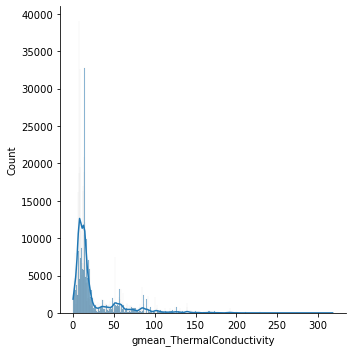

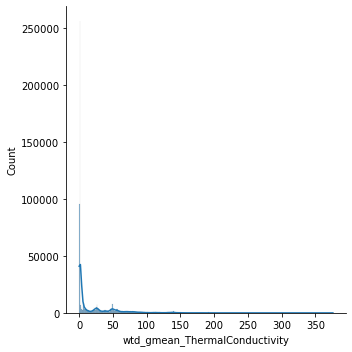

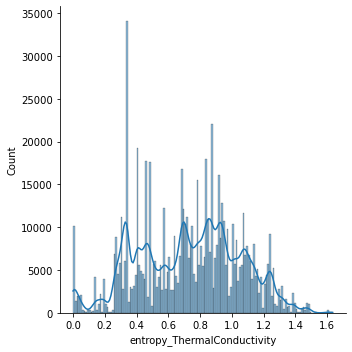

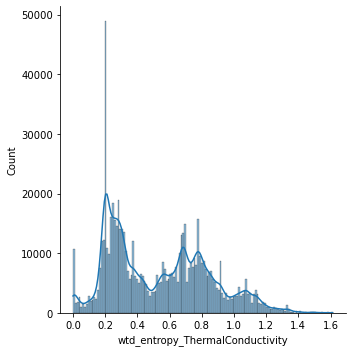

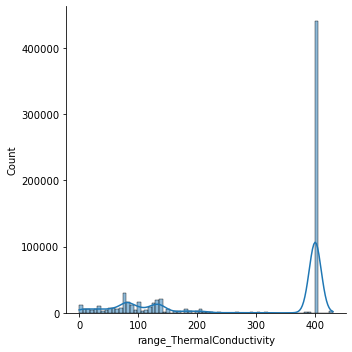

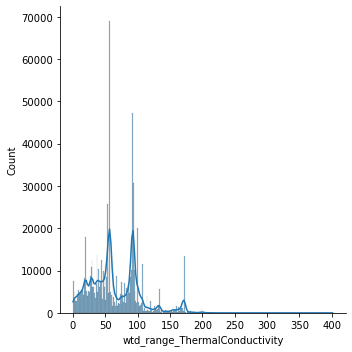

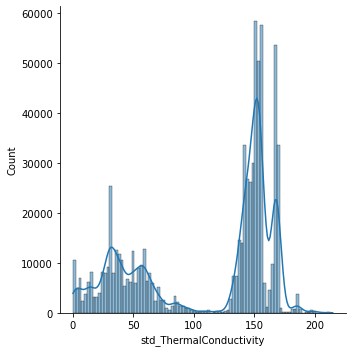

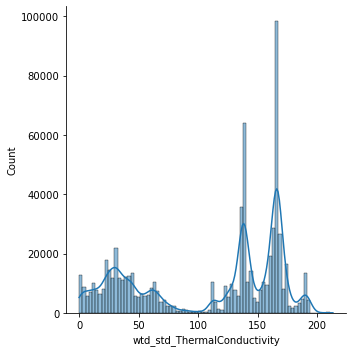

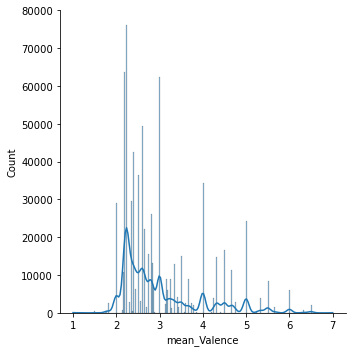

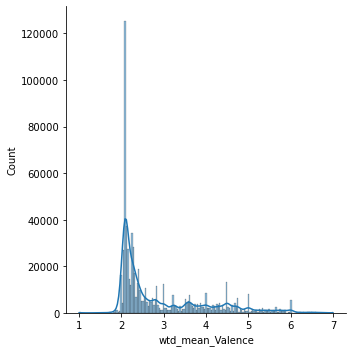

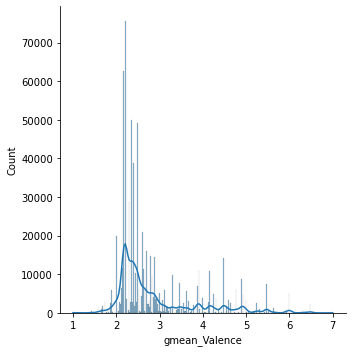

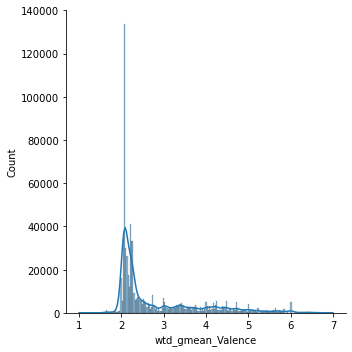

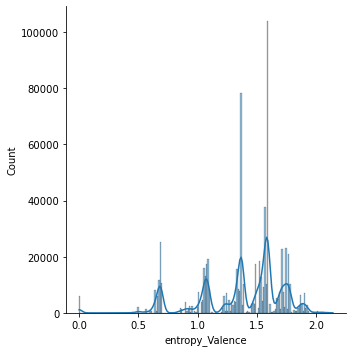

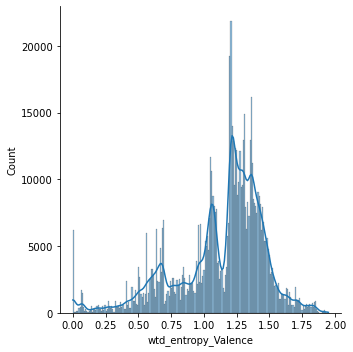

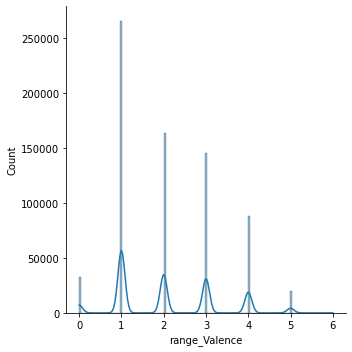

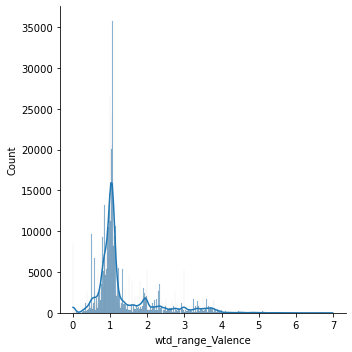

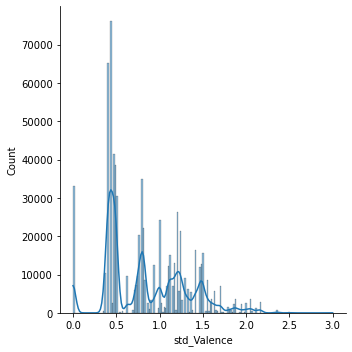

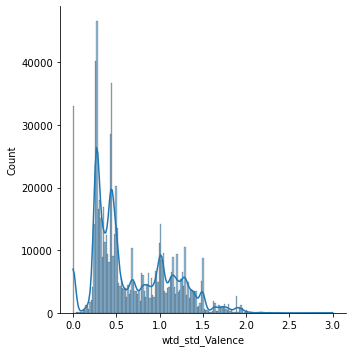

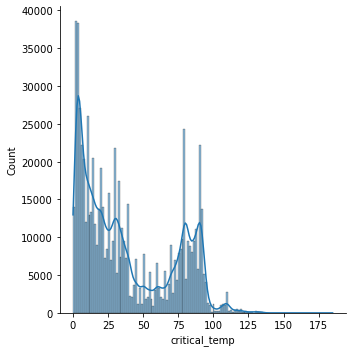

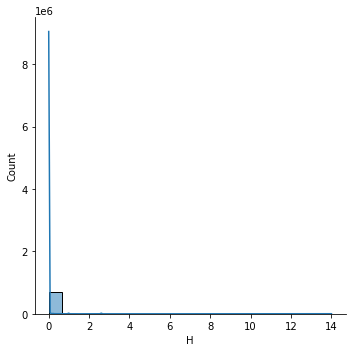

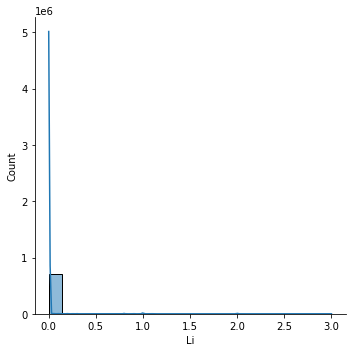

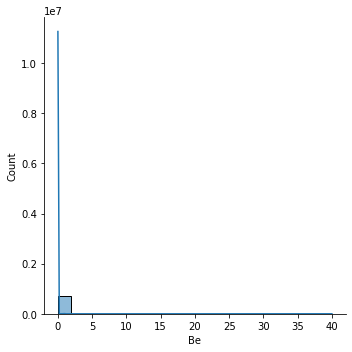

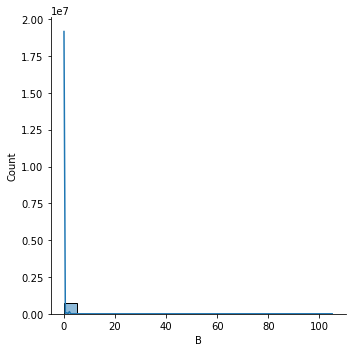

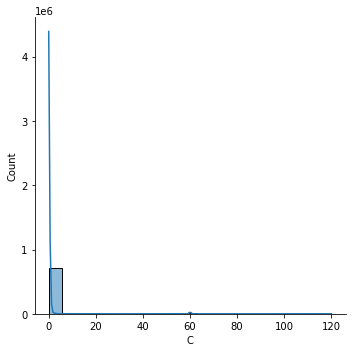

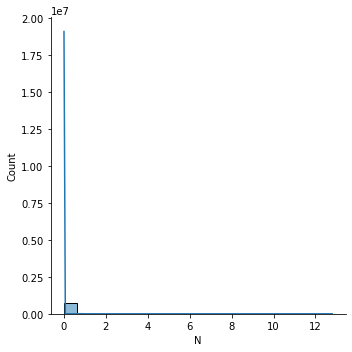

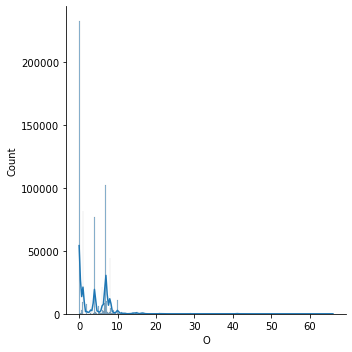

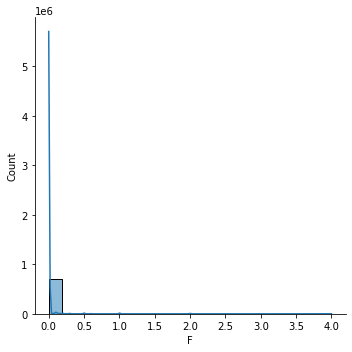

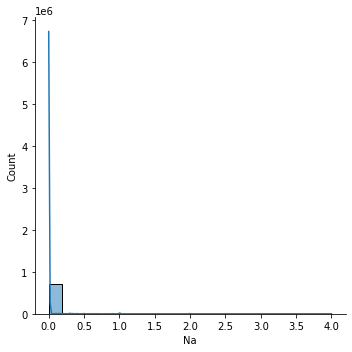

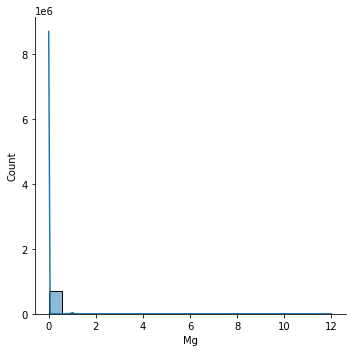

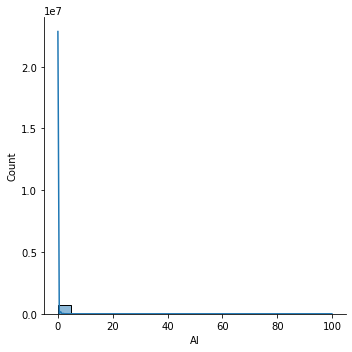

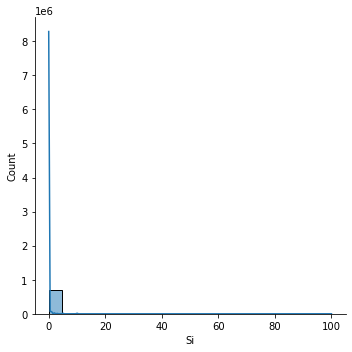

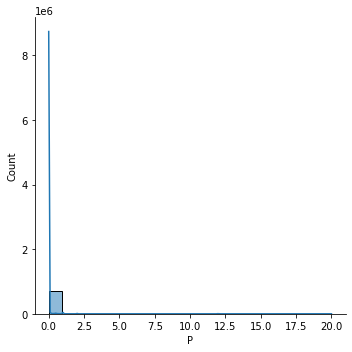

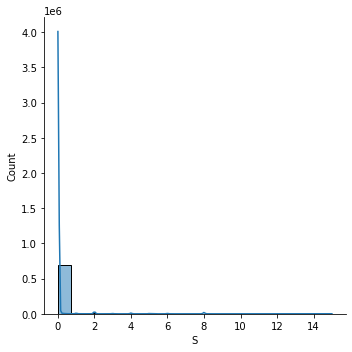

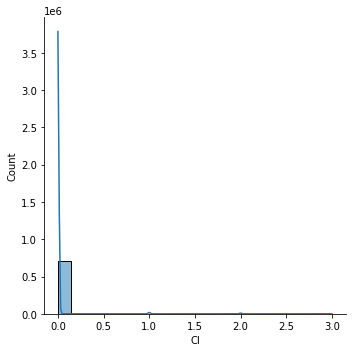

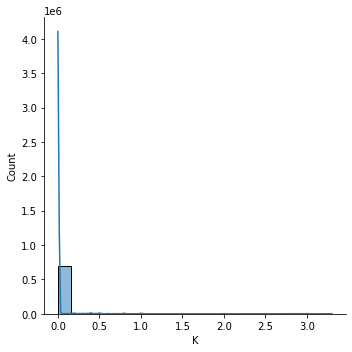

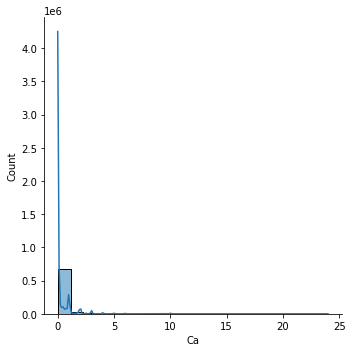

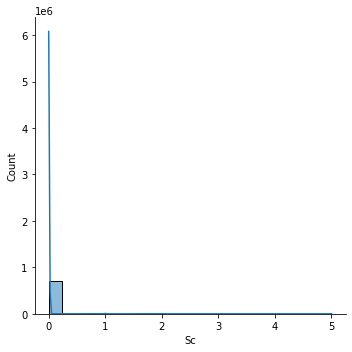

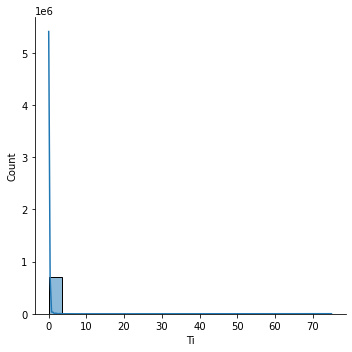

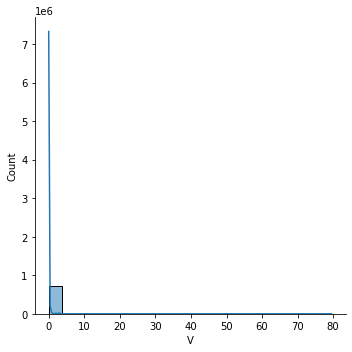

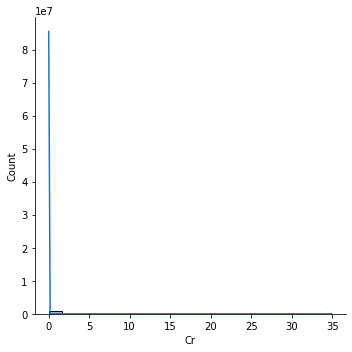

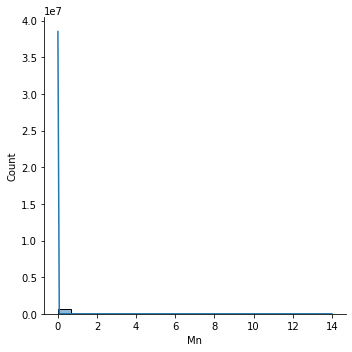

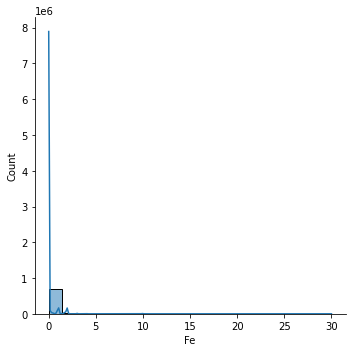

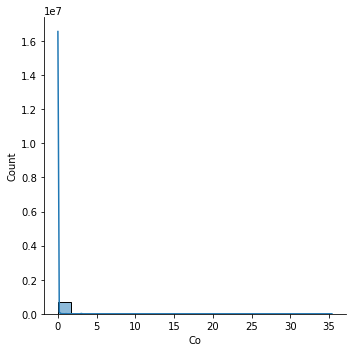

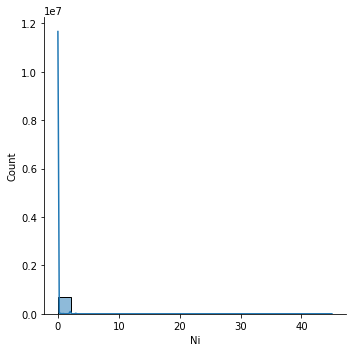

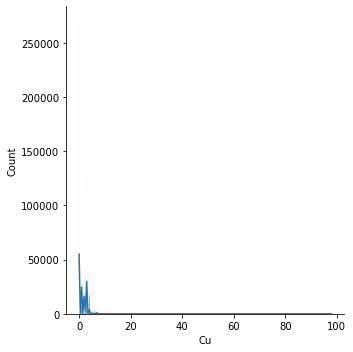

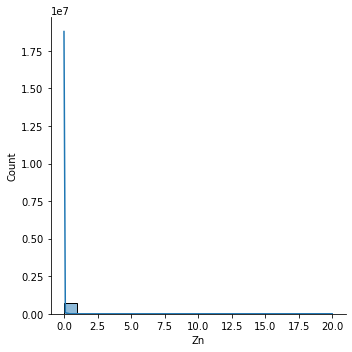

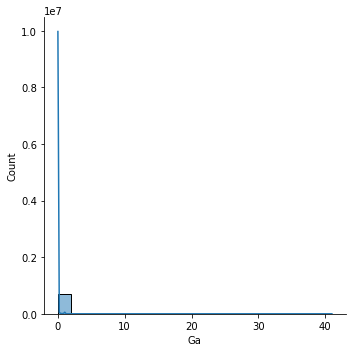

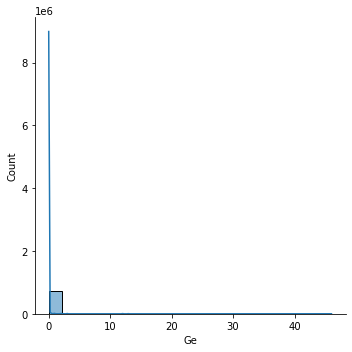

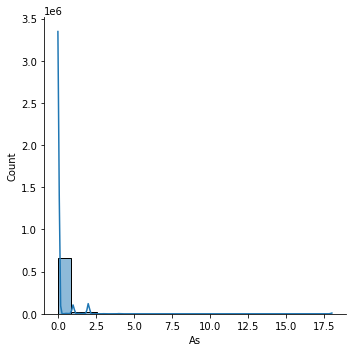

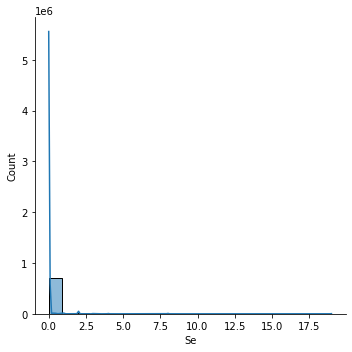

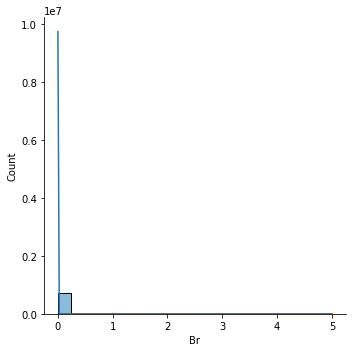

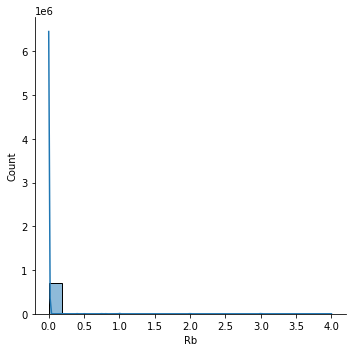

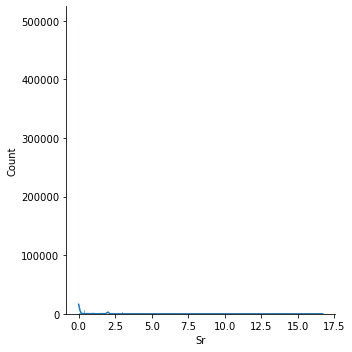

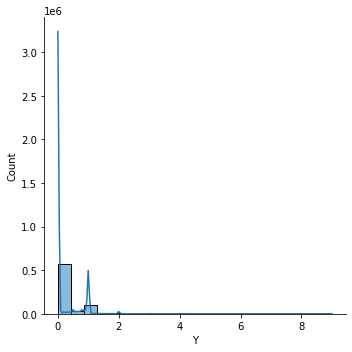

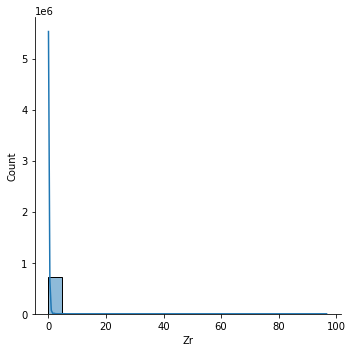

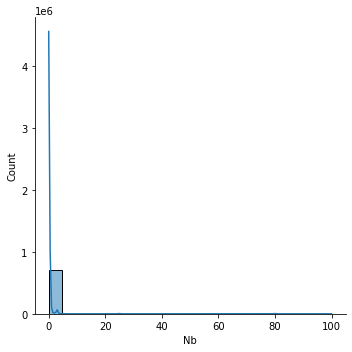

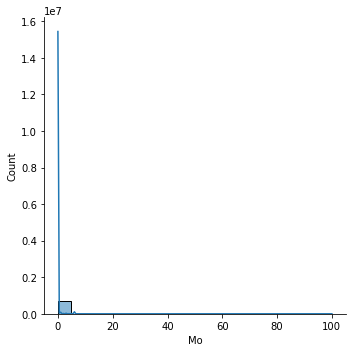

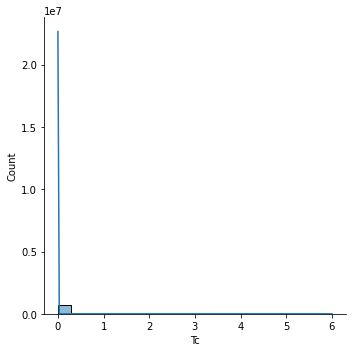

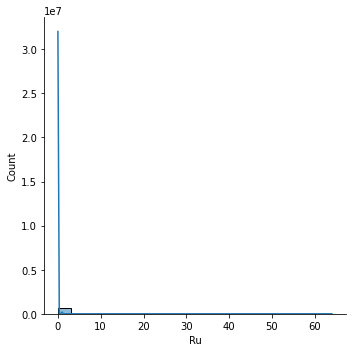

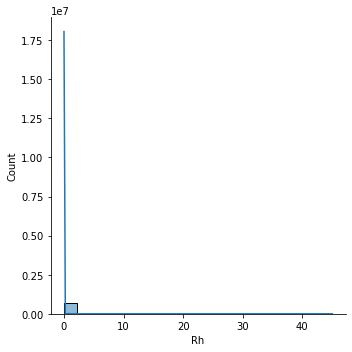

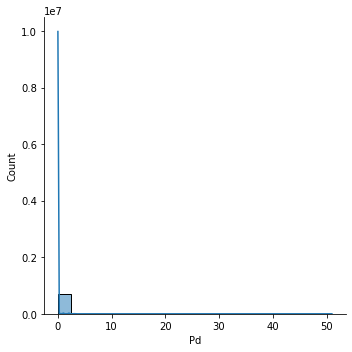

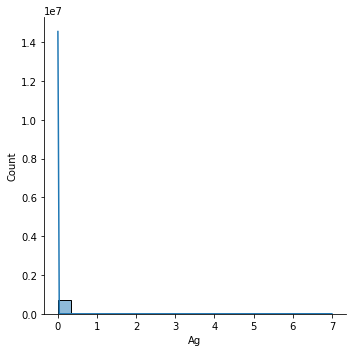

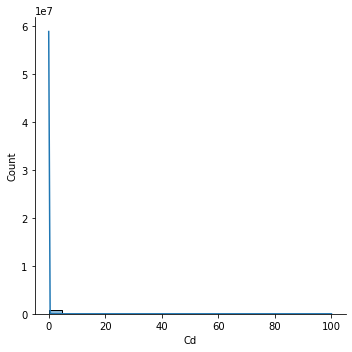

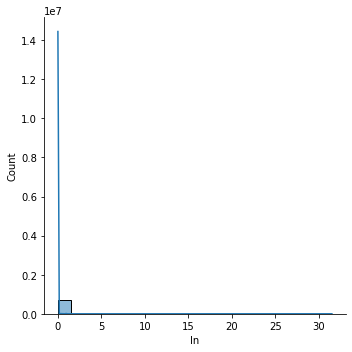

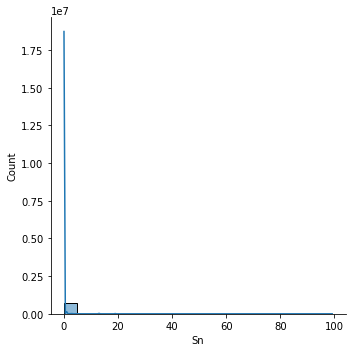

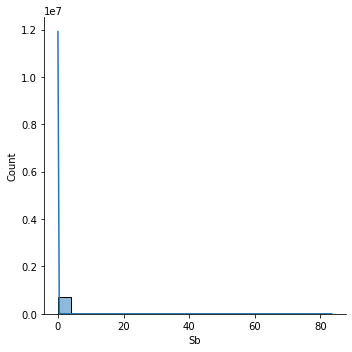

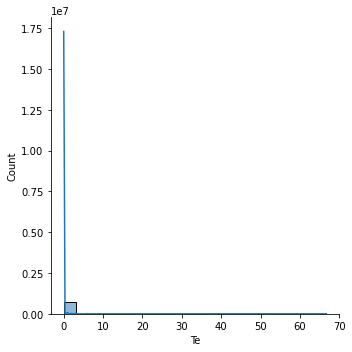

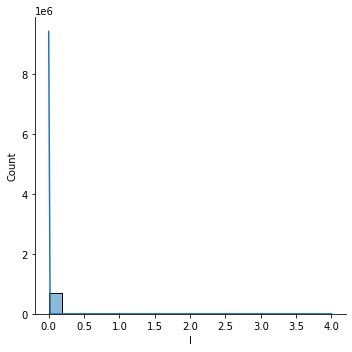

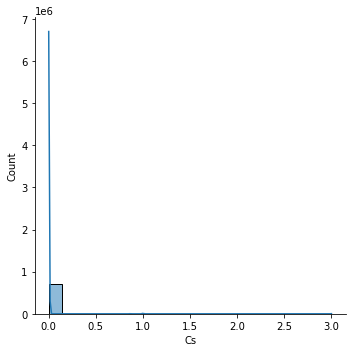

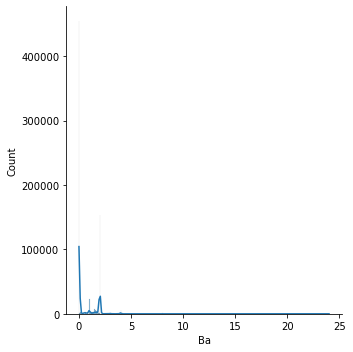

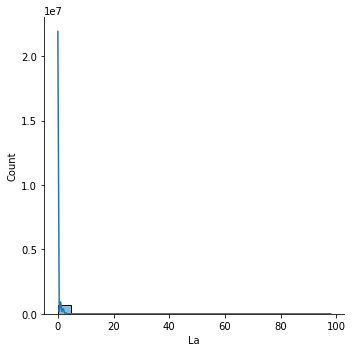

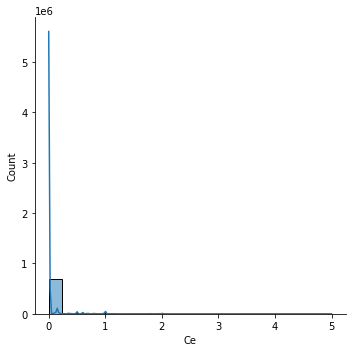

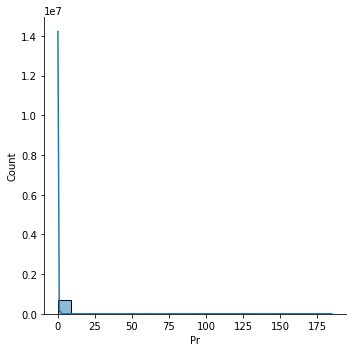

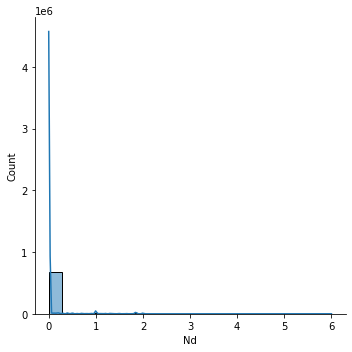

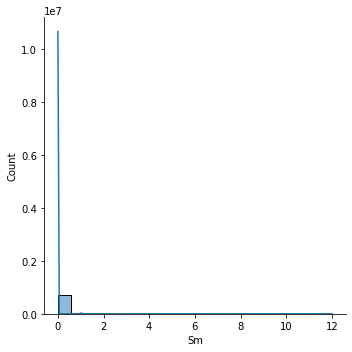

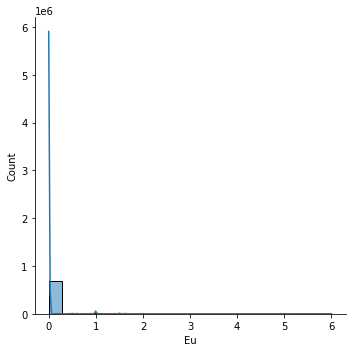

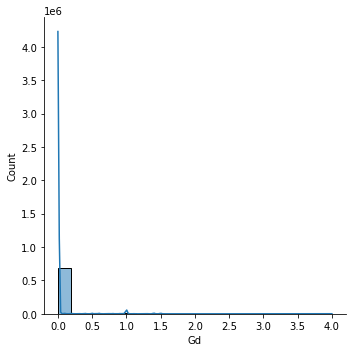

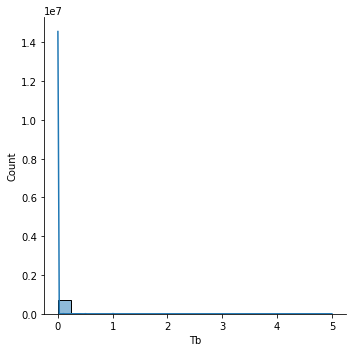

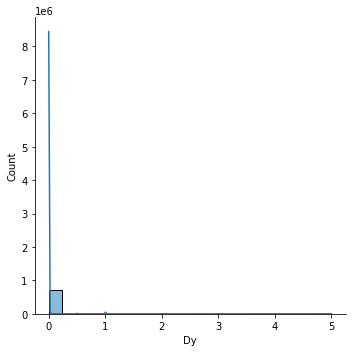

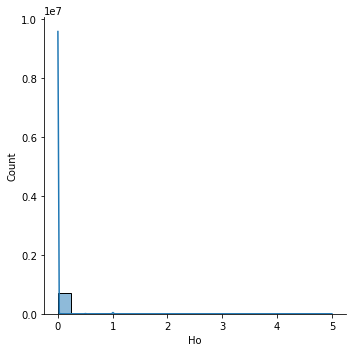

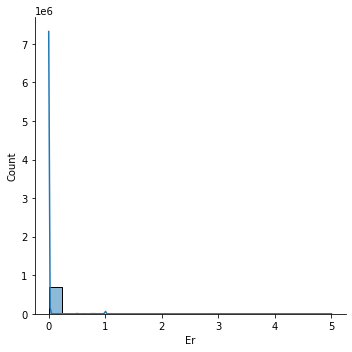

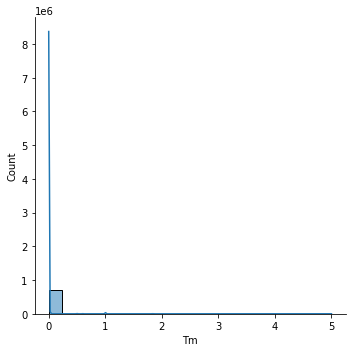

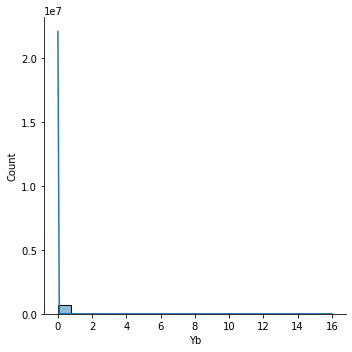

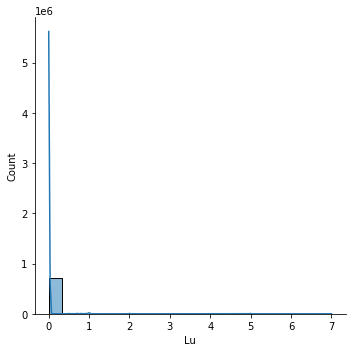

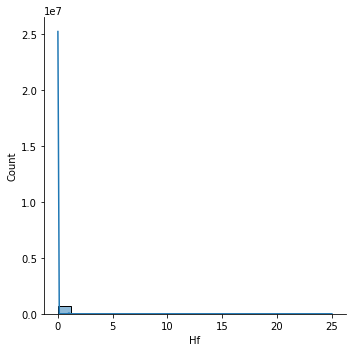

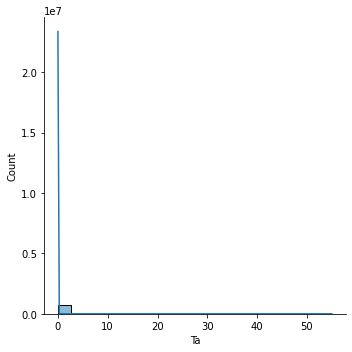

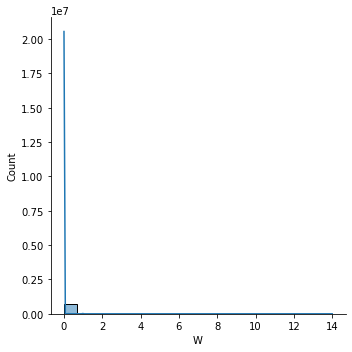

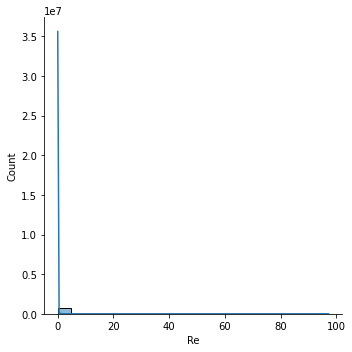

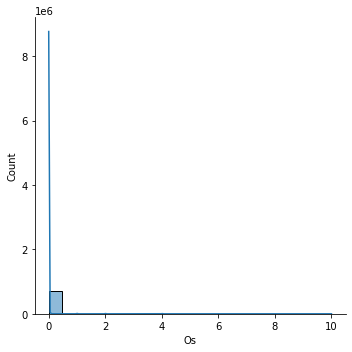

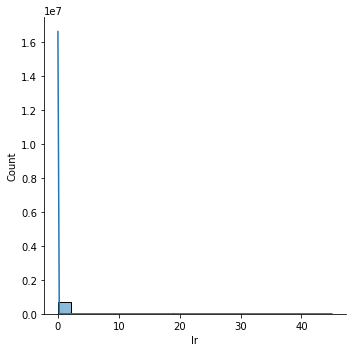

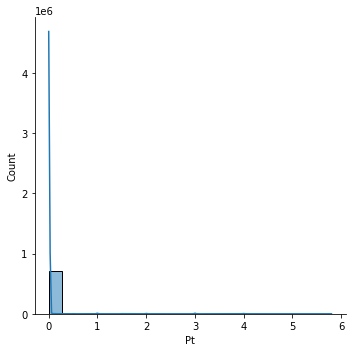

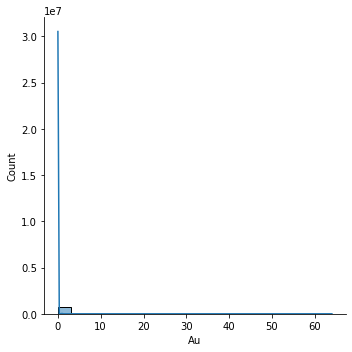

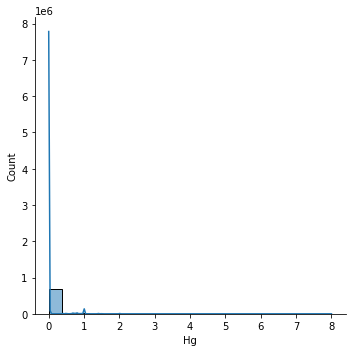

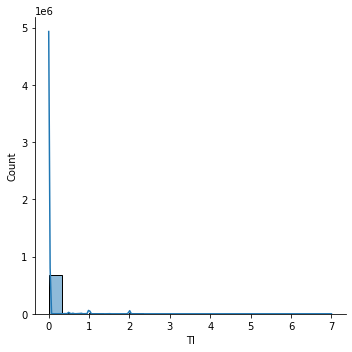

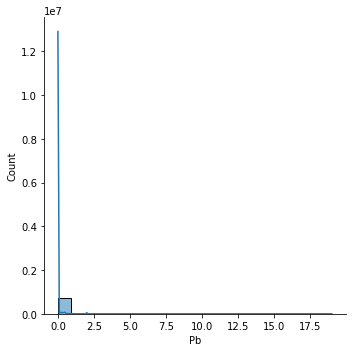

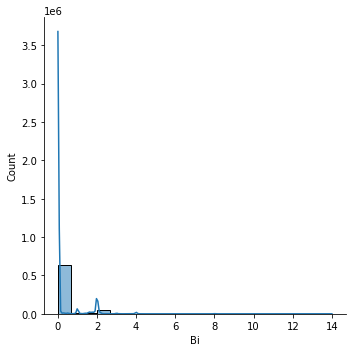

In [57]:
for i in df.columns:
    sns.displot(df[i], kde=True)
    plt.show()

# Preprocess

After prelim eda, we see that normalcy is met thus standard scaler is the most useful scaler for this data. For completeness, we showed that the internal cross validation metrics between scaled and unscaled data is quite similar for plain linear regression.

In [12]:
X = df.drop(columns="critical_temp")
y = df["critical_temp"]

## No scaling

In [13]:
lr = LinearRegression()

In [14]:
lr.fit(X, y)

LinearRegression()

In [22]:
split = KFold(shuffle=True, n_splits=5)
scores = cross_validate(lr, X, y, 
                        cv=split,
                        scoring=('r2', 'neg_root_mean_squared_error'),
                        return_train_score=True,
                        n_jobs = -1)
scores = pd.DataFrame(scores)
scores

,fit_time,score_time,test_r2,train_r2,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error
0,18.362718,0.103862,0.740772,0.738548,-16.391583,-16.463560
1,17.726166,0.087462,0.739543,0.738855,-16.455579,-16.447565
2,18.366008,0.104632,0.737564,0.739332,-16.483936,-16.441024
3,18.156360,0.096675,0.738177,0.739197,-16.488667,-16.439298
4,16.331243,0.097578,0.738183,0.739192,-16.448613,-16.449399


In [27]:
# 5 fold internal cv on full data
print("Nonscaled r2: %.3f" % scores["test_r2"].mean())
print("Nonscaled rmse: %.3f" % np.abs(scores["test_neg_root_mean_squared_error"].mean()))

Nonscaled r2: 0.739
Nonscaled rmse: 16.454


## Standard Scaler

In [34]:
pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("lr", LinearRegression())
])

Pipeline(steps=[('scaler', StandardScaler()), ('lr', LinearRegression())])

In [ ]:
pipe.fit(X, y)

In [35]:
split = KFold(shuffle=True, n_splits=5)
scores = cross_validate(std_scale_pipe, X, y, 
                        cv=split,
                        scoring=('r2', 'neg_root_mean_squared_error'),
                        return_train_score=True,
                        n_jobs = -1)
scores = pd.DataFrame(scores)
scores

,fit_time,score_time,test_r2,train_r2,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error
0,19.447697,0.308221,0.739445,0.738880,-16.431048,-16.453706
1,20.564017,0.122064,0.738851,0.739027,-16.439128,-16.451679
2,20.337529,0.128411,0.740115,0.738710,-16.439245,-16.451707
3,20.752005,0.126146,0.737040,0.739475,-16.506535,-16.434947
4,18.600774,0.158027,0.738866,0.739022,-16.449705,-16.449098


In [36]:
# 5 fold internal cv on full data
print("std scale r2: %.3f" % scores["test_r2"].mean())
print("std scale rmse: %.3f" % np.abs(scores["test_neg_root_mean_squared_error"].mean()))

std scale r2: 0.739
std scale rmse: 16.453


In [37]:
min_max_scale_pipe = Pipeline([("min_max_scaler", MinMaxScaler()), ("lr", lr)])
min_max_scale_pipe.fit(X, y)

Pipeline(steps=[('min_max_scaler', MinMaxScaler()), ('lr', LinearRegression())])

In [38]:
split = KFold(shuffle=True, n_splits=5)
scores = cross_validate(min_max_scale_pipe, X, y, 
                        cv=split,
                        scoring=('r2', 'neg_root_mean_squared_error'),
                        return_train_score=True,
                        n_jobs = -1)
scores_df = pd.DataFrame(scores)
scores_df

,fit_time,score_time,test_r2,train_r2,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error
0,18.846190,0.201981,0.740423,0.738634,-16.406122,-16.459945
1,18.414282,0.129145,0.738697,0.739062,-16.468563,-16.444467
2,20.014883,0.115879,0.738959,0.738999,-16.465913,-16.445053
3,19.425322,0.139421,0.738869,0.739021,-16.451357,-16.448695
4,20.189246,0.135271,0.737337,0.739400,-16.474965,-16.442863


In [39]:
# 5 fold internal cv on full data
print("min max scaled r2: %.3f" % scores["test_r2"].mean())
print("min max scaled rmse: %.3f" % np.abs(scores["test_neg_root_mean_squared_error"].mean()))

min max scaled r2: 0.739
min max scaled rmse: 16.453


# Modeling

## L1 / LASSO - Slater's way

In [35]:
lasso = Lasso(max_iter = 5_000, random_state=77)
scale = StandardScaler()
X_scaled = pd.DataFrame(scale.fit_transform(X), columns=X.columns)

In [39]:
best = -1_000_000_000
best_alpha = "error"
alphas = np.logspace(-2, 2, 100)

In [33]:
for i in alphas:
    lasso.alpha = i
    split = KFold(shuffle=True, n_splits=5)
    out = cross_val_score(lasso, X_scaled, y, cv=split, scoring='neg_root_mean_squared_error', n_jobs=-1).mean()
    if out > best:
        best = out
        best_alpha = i
print(f"best rmse: {best}")
print(f"best lambda: {best_alpha}")

best rmse: -17.045401363268592
best lambda: 0.1


### Feature importance

In [ ]:
# absolute values of coefficients


## L1 / Lasso gridsearch - the right way in practice

In [ ]:
lasso_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ('model', Lasso())
])

params = {'model__alpha': (np.logspace(-8, 8, 100))} # It will check from 1e-08 to 1e+08

lasso_gs = GridSearchCV(lasso_pipeline, params, cv = 10)

lasso_gs.fit(X, y)



In [ ]:
gs_df = lasso_gs.cv_results_

In [ ]:
lasso_pipeline.score(X_test, y_test)

In [ ]:
lasso_pipeline.named_steps['model'].coef_

### Feature importance

## L2 / Ridge - Slater's way

### Feature importance

## L2 / Ridge gridsearch

In [ ]:
lasso_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ('model', Ridge())
])

params = {'model__alpha': (np.logspace(-8, 8, 100))} # It will check from 1e-08 to 1e+08

lasso_gs = GridSearchCV(lasso_pipeline, params, cv = 10)

lasso_gs.fit(X, y)

